In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from nitools.firstlevel import Dataset
from nistats.hemodynamic_models import glover_hrf

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Define data+task set
Corresponding BIDS-dir, subject-identifier, etc. etc.

In [3]:
ds = Dataset(bids_dir='/home/lsnoek1/spinoza_data/ni-edu/bids', sub='02', n_jobs=2)
ds.create_taskset(
    task='flocBLOCKED',
    space='fsaverage6',
    tr=0.7,
    acq=None,
    ses=True,
    hemi='R',
    reference_run=-1,
    use_gm_mask=True,
    gm_threshold=0.5
)

Found 2 complete runs for task flocBLOCKED


## Check floc (BLOCKED) localizer

In [4]:
ds.flocBLOCKED.preprocess(
    df_filter=None,
    regress_confounds=False,
    conf_vars=None,
    smoothing_fwhm=3,
    hp_cutoff=100
)

Preprocessing data for task flocBLOCKED ...


In [11]:
ds.flocBLOCKED.glm_detect(hrf_model='glover')
floc_mask = ds.flocBLOCKED.compute_fxe('4*face - object - place - body - character', stat_type='t')
ds.visualize(floc_mask, space='fsaverage6', threshold=3)

Running a GLM for task flocBLOCKED ...
Computing contrast: 4*face - object - place - body - character for task flocBLOCKED ...
Visualizing statmap on surface ...


In [ ]:
ds.flocBLOCKED.plot_design(exclude_confs=True)

## Check floc (ER) HRF mapper

In [6]:
ds.create_taskset(
    task='flocER',
    space='fsaverage6',
    tr=0.7,
    acq=None,
    ses=True,
    hemi='R',
    reference_run=-1,
    use_gm_mask=True,
    gm_threshold=0.5
)

Found 2 complete runs for task flocER


In [7]:
ds.flocER.preprocess(
    df_filter=None,
    regress_confounds=False,
    conf_vars=None,
    smoothing_fwhm=5,
    hp_cutoff=100
)

Preprocessing data for task flocER ...


In [12]:
ds.flocER.glm_detect(hrf_model='glover + derivative')
floc_mask = ds.flocER.compute_fxe('4*face - object - place - body - character', stat_type='t')
ds.visualize(floc_mask, space='fsaverage6', threshold=1)

Running a GLM for task flocER ...
Computing contrast: 4*face - object - place - body - character for task flocER ...
Visualizing statmap on surface ...


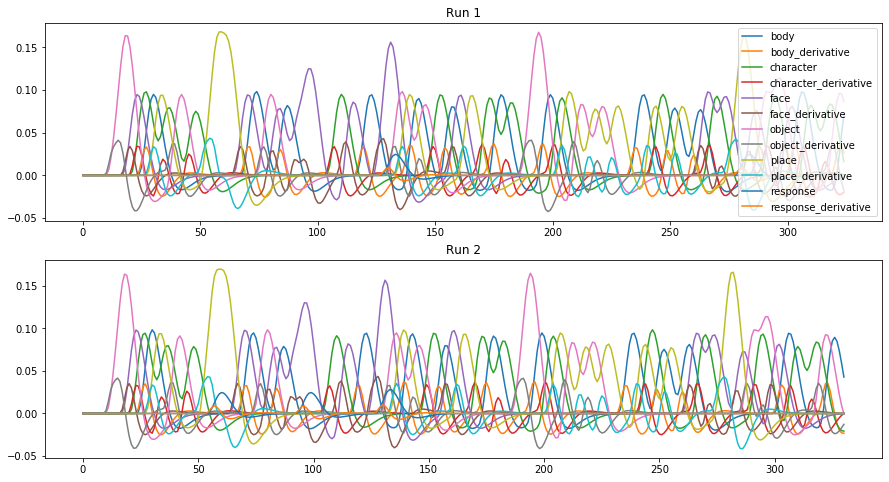

In [13]:
ds.flocER.plot_design(exclude_confs=True)

### Fit Responsefitter

In [ ]:
ds.flocER.shape_estimation(
    osf=30,
    TR=0.7,
    slice_time_ref=0.5,
    n_regressors=7,
    basis_set='fourier',
    interval=[0, 14],
    separate_conditions=False
)

In [ ]:
ds.plot_hrfs(taskset='flocER', rsq_cutoff=0.2)

Or plot them for the FFA (for face-HRFs only):

In [ ]:
ds.plot_hrfs(taskset='flocER', mask=floc_mask > 3, condition='face')

## For all subjects

In [ ]:
import numpy as np
subs = [str(s).zfill(2) for s in np.arange(2, 14)]
results = []
for sub in subs:
    if sub == '10':
        continue

    ds = Dataset(bids_dir='/home/lsnoek1/spinoza_data/ni-edu/bids', sub=sub, n_jobs=2)
    ds.create_taskset(
        task='flocBLOCKED',
        space='MNI152NLin2009cAsym',
        tr=0.7,
        acq=None,
        ses=True,
        hemi='R',
        reference_run=-1,
        use_gm_mask=True,
        gm_threshold=0.5
    )

    ds.flocBLOCKED.preprocess(
        df_filter=None,
        regress_confounds=False,
        conf_vars=None,
        smoothing_fwhm=5,
        hp_cutoff=100
    )
    ds.flocBLOCKED.glm_detect(hrf_model='glover')
    floc_mask = ds.flocBLOCKED.compute_fxe('4*face - object - place - body - character', stat_type='t')
    results.append(floc_mask)

In [ ]:
import pandas as pd
from nistats.second_level_model import SecondLevelModel
slm = SecondLevelModel(smoothing_fwhm=5)
X = pd.DataFrame(columns=['intercept'])
X['intercept'] = np.ones(len(results))
slm.fit(results, design_matrix=X)

In [ ]:
slm_img = slm.compute_contrast(
    second_level_contrast='intercept',
    second_level_stat_type='t',
    output_type='z_score'
)
from nilearn.plotting import view_img
view_img(slm_img, bg_img=False, threshold=2)

## Single-trial faces

In [ ]:
import pandas as pd
def filter_face(df):
    df_filt = df.query("face_sex == 'male' or face_sex == 'female'")
    df_filt['trial_type'] = 'face_mod'
    df_filt['modulation'] = df_filt['average_attractiveness']
    unmod = df_filt.copy()
    unmod['trial_type'] = 'face_unmod'
    unmod['modulation'] = 1
    df_filt = pd.concat((unmod, df_filt), axis=0).sort_values('onset', axis=0)
    return df_filt

In [ ]:
ds.create_taskset(
    task='face',
    space='fsaverage6',
    tr=0.7,
    acq=None,
    ses=True,
    hemi='R',
    reference_run=-1,
    use_gm_mask=True,
    gm_threshold=0.5
)

In [ ]:
ds.face.preprocess(
    df_filter=filter_face,
    regress_confounds=False,
    conf_vars=None,
    smoothing_fwhm=3,
    hp_cutoff=100
)

In [ ]:
ds.face.glm_detect(hrf_model='glover')

In [ ]:
ds.face.plot_design()

In [ ]:
mod_mask = ds.face.compute_fxe('face_mod', stat_type='t')
ds.visualize(mod_mask, space='fsaverage6', threshold=2)

## Check out different contrasts
E.g., face sex.

In [ ]:
def filter_face_expression(df):
    df_filt = df.query("face_sex == 'male' or face_sex == 'female'")
    df_filt['trial_type'] = df_filt['expression']
    return df_filt

In [ ]:
ds.face.preprocess(
    df_filter=filter_face_expression,
    regress_confounds=False,
    conf_vars=None,
    smoothing_fwhm=3,
    hp_cutoff=100
)

In [ ]:
ds.face.glm_detect(hrf_model='glover + derivative')
mod_mask = ds.face.compute_fxe('smiling-neutral', stat_type='t')
ds.visualize(mod_mask, space='fsaverage6', threshold=2)

In [ ]:
ds.face.preprocess(smoothing_fwhm=4, df_filter=filter_face_sex)
ds.face.glm_detect(hrf_model='glover', noise_model='ols', TR=.7)
face_sex_img = ds.face.compute_fxe('female - male', stat_type='t')
ds.visualize(face_sex_img, surface=True, threshold=3, hemi='R')

Or parametric modulation of attractiveness.

In [ ]:
def filter_face_attractiveness(df):
    df_filt = df.query("event_type == 'face' & phase == 0").drop('trial_type', axis=1)
    df_filt['trial_type'] = 'face'
    df_filt['modulation'] = 1
    df2 = df_filt.copy()
    mod = df2.loc[:, 'attractiveness'].values
    df2.loc[:, 'modulation'] = mod - mod.mean()
    df2['trial_type'] = 'face_attractiveness'
    df = pd.concat((df_filt, df2), axis=0)
    return df

In [ ]:
ds.face.preprocess(smoothing_fwhm=4, df_filter=filter_face_attractiveness)
ds.face.glm_detect(hrf_model='glover', noise_model='ols', TR=.7)
face_attractiveness_img = ds.face.compute_fxe('face_attractiveness', stat_type='t')
ds.visualize(face_attractiveness_img, surface=True, threshold=3, hemi='R')